# 实验4 图像分类

**10185501402 孙秋实 2018级**

本节课使用 CIFAR-10 数据集，用 pytorch（或其他框架）搭建模型进行图像分类。

CIFAR-10 数据集：http://www.cs.toronto.edu/~kriz/cifar.html

下载相应的Cifar-10数据集放在目录中，使用dset调用，随后搭建了一个卷积神经网络用于图像分类任务，并且对比了两种不同激活函数在相同参数配置下的性能

# 准备工作

在一切开始之前，我们先做一些准备工作，检查GPU是否可用，然后安装/加载相应的Python库帮助我们的实验

In [69]:
import numpy as np
import os
import platform
import pickle
import matplotlib.pyplot as plt

In [70]:
import hiddenlayer as h
import tensorwatch as tw
import torchvision.models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as sched
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as T

In [71]:
torch.__version__ 

'1.8.1+cu102'

In [72]:
torch.cuda.is_available()

True

## 数据预处理

我们在加载数据时即做一下归一化处理，这里需要先去求得均值和方差，如下所示，transform_val为用于归一化的数据，分别用到训练集，验证集，测试集

咨询了助教老师后发现可能对比较深的cnn而言这种变换带来的性能提升有限，毕竟cnn本来就是在学习数据分布的特征，所以归一化并不会起特别明显的作用，不过还是在这里做了，希望它能给模型性能带来一些提升

In [73]:
transform_val = T.Compose([
                T.ToTensor(),
                # 求出的均值与方差，用于归一化
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

这里从Cifar-10数据集获得图片数据

In [74]:
train_num = 49000

cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,transform=transform_val)
cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,transform=transform_val)
cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, transform=transform_val)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [75]:
def get_mean_std(dataset, ratio=0.01): # 获得均值方差
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=int(len(dataset)*ratio), 
                                         shuffle=True, num_workers=10)
    train = iter(dataloader).next()[0]   # 一个batch的数据
    mean = np.mean(train.numpy(), axis=(0,2,3))
    std = np.std(train.numpy(), axis=(0,2,3))
    return mean, std

In [8]:
train_mean, train_std = get_mean_std(cifar10_train)

In [9]:
val_mean, val_std = get_mean_std(cifar10_val)

获得用于transform的数据

In [76]:
loader_train = DataLoader(cifar10_train, batch_size=128, sampler=sampler.SubsetRandomSampler(range(train_num)))

loader_val = DataLoader(cifar10_val, batch_size=128, sampler=sampler.SubsetRandomSampler(range(train_num, 50000)))

loader_test = DataLoader(cifar10_test, batch_size=128)

我们已经成功将数据封装进入DataLoader，我们在训练时直接调用即可

## 查看Cifar-10数据集

我们直接加载在Cifar-10数据集，现在来查看一下这些图片到底是些什么

In [78]:
def load_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

# 加载Pickle文件
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

# 加载Cifar-10数据集
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [79]:
cifar10_dir = 'datasets/cifar-10-batches-py'
# 加载Cifar-10数据集用于可视化
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [81]:
# 可视化部分数据
# 这里我们每个类别展示了 7 张图片
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

在开始对Cifar-10数据集分类的实验开始之前，我们先看一下数据的情况，获得一些感性的认识。

将每个类对应的一些图片打印下来，每个类6张图片

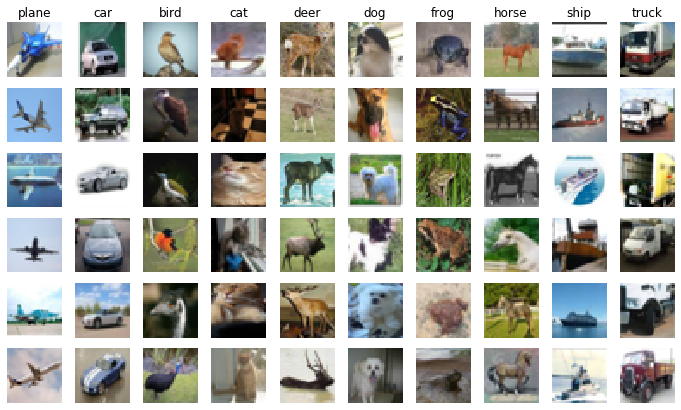

In [82]:
samples_per_class = 6
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        plt.gcf().set_size_inches(12, 7)
        if i == 0:
            plt.title(cls)
plt.show()

接下来选择GPU，这里稍微蹭了一下陆老师实验室的GPU用于训练

In [86]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-32GB'

In [87]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device=torch.device("cuda:0")
    # 蹭了一下实验室的GPU
else:
    device = torch.device('cpu')

print('Using Device:', device)

Using Device: cuda:0


# 卷积神经网络结构

## 卷积神经网络的搭建

在本次实验中，我依托计算机视觉领域经典的AlexNet为模版，借助Pytorch搭建了一个类似的卷积神经网络网络用于实验

对模型进行了一些精简，主要修改如下

1. 去除了原文中的一个池化层
2. 将一个MaxPooling层改为了AveragePooling层
3. 不使用LRN（局部响应归一化层）

**Remark**

去除掉的LRN层是原始论文中防止激活输出过大所用的归一化层，可以起到一定的正则效果。

LRN使用n个相邻activationmaps中同一位置的输出去进行归一化，数学形式表达如下

$$b_{x, y}^{i}=a_{x, y}^{i} /\left(k+\alpha \sum_{j=\max (0, i-n / 2)}^{\min (N-1, i+n / 2)}\left(a_{x, y}^{j}\right)^{2}\right)^{\beta}$$

LRN在Batch Normalization出现后基本已经弃用，Pytorch中也弃用了相应的模组，所以本次实验只在这里做一点简单的了解。


In [88]:
model = None
optimizer = None

class Modified_Alex_Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Modified_Alex_Net, self).__init__()
        self.relu=nn.ReLU(inplace=True) 
        # ReLU 函数
        # inplace = True 让ReLU 不需要介入一个中间变量就可以直接更新
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            self.relu,
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            self.relu,
#             nn.MaxPool2d(kernel_size=2),
            # AlexNet的原文中的池化层可以依据情况删去

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            self.relu,

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            self.relu,
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        # 此处是自适应平均池化函数
        # 自动计算kernel size和step

        self.classifier = nn.Sequential(
            nn.Dropout(0.5), # 默认dropout = 0.5
            nn.Linear(256 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), # 默认dropout = 0.5
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x: Tensor = self.avgpool(x)
        x = x.view(-1, 7 * 7 * 256)
        x = self.classifier(x)
        return x

加载模型，设置学习率和优化器方法

In [102]:
model = Modified_Alex_Net().to(device) # 
learning_rate = 5e-4
optimizer=optim.Adam(model.parameters(),
                     lr=learning_rate, 
                     weight_decay=1e-5)

# 之前考虑过使用学习率衰减/衰减+热重启的方式
# scheduler = sched.StepLR(optimizer, step_size=50, gamma = 0.9)
# 用这个sheduler可以做学习率衰减，但是我们使用adam的话就不需要了

## 模型结构可视化

搭建好我们的模型后，我们借助tensorwatch模组来查看下我们搭建的网络的结构和参数情况

In [103]:
My_AlexNet_Model = Modified_Alex_net()
tw.model_stats(My_AlexNet_Model, [1, 3, 224, 224])

,module name,input shape,output_shape,parameters,infer memory(MB),MAdd,Flops,MemRead(B),MemWrite(B),duration
0,relu,"(1, 256, 112, 112)","(1, 256, 112, 112)",0,12.25,"3,211,264","3,211,264","12,845,056","12,845,056",0.000190
1,features.0,"(1, 3, 224, 224)","(1, 64, 224, 224)","1,792",12.25,"173,408,256","89,915,392","609,280","12,845,056",0.007783
2,features.2,"(1, 64, 224, 224)","(1, 64, 112, 112)",0,3.0625,"3,211,264","3,211,264","12,845,056","3,211,264",0.002024
3,features.3,"(1, 64, 112, 112)","(1, 192, 112, 112)","110,784",9.1875,"2,774,532,096","1,389,674,496","3,654,400","9,633,792",0.010519
4,features.5,"(1, 192, 112, 112)","(1, 384, 112, 112)","663,936",18.375,"16,647,192,576","8,328,413,184","12,289,536","19,267,584",0.011270
5,features.7,"(1, 384, 112, 112)","(1, 256, 112, 112)","884,992",12.25,"22,196,256,768","11,101,339,648","22,807,552","12,845,056",0.011688
6,avgpool,"(1, 256, 112, 112)","(1, 256, 7, 7)",0,0.0478515625,0,"3,625,216",0,0,0.000539
7,classifier.0,"(1, 12544)","(1, 12544)",0,0.0478515625,0,0,0,0,0.000025
8,classifier.1,"(1, 12544)","(1, 4096)","51,384,320",0.015625,"102,756,352","51,380,224","205,587,456","16,384",0.005473
9,classifier.2,"(1, 4096)","(1, 4096)",0,0.015625,"4,096","4,096","16,384","16,384",0.000032


In [104]:
training_loss = []
validation_accuracy = []
# 使用两个空列表来记录数据，帮助可视化

def train_model(model, optimizer, epochs=1):
    iter = 0
    model = model.to(device=device)  
    # 加载模型到GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  
            # 模型训练
            x = x.to(device=device, dtype=dtype) 
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            training_loss.append(loss.item()) # append数据用于可视化
            optimizer.zero_grad() # 梯度清空
            loss.backward() # 反向传播
            optimizer.step() # 使用优化方法更新
#             if t % 256 == 0:
#                 print('Iteration %d, loss = %.4f' % (t, loss.item()))
#                 check_model_accuracy(loader_val, model)              
            if iter % 200 == 0:
                print('Iteration %d, loss = %.4f' % (iter, loss.item()))
                validation_accuracy.append(check_model_accuracy(loader_val, model))
            iter = iter + 1

**Remark:** 这里需要注意，因为我们的loss的类型是Tensor，所以不要直接append在我们的数组后面，我们需要使用loss.item()取出它的值，再利用它进行可视化

使用一个函数用来检查正确率

In [105]:
def check_model_accuracy(loader, model):
    if loader.dataset.train:
        print('（验证集准确率）Checking accuracy on validation set')
    else:
        print('（测试集准确率）Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() 
    # 模型评估
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
#         validation_accuracy.append(acc)
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

下面实现两个可视化工具

In [106]:
def visualize_loss_curve(data1):
    line1,=plt.plot(data1,'royalblue',label='training_loss')
    plt.title('Visualize Training Loss')
    plt.legend(handles=[line1],labels=['Training loss'], loc='best')
    plt.grid(linestyle='-.')
    plt.gcf().set_size_inches(12, 7)
    plt.xlabel('Iteration')
    plt.ylabel('Training_loss')
    plt.show()

In [107]:
def visualize_accuracy(data1):
    line1,=plt.plot(data1,'slateblue',label='Validation Accuracy')
    plt.title('Visualize Validation Accuracy')
    plt.legend(handles=[line1],labels=['Validation Accuracy'], loc='best')
    plt.grid(linestyle='-.')
    plt.gcf().set_size_inches(8, 5)
    plt.xlabel('Iteration')
    plt.ylabel('Validation Accuracy')
    plt.show()

# 训练神经网络

接下来我们开始训练模型，并且检查其在验证集和测试集上的表现

对于这个Cifar-10数据集而言，盲猜的准确率是10%，我们希望它的性能能尽可能的高，比如接近90%的测试集准确率

对于我们的CNN而言，训练集准确率并没有什么用，我们在数据预处理时选定了一部分数据作为验证集，我们在实验中考虑验证集的表现，最后将其运用于测试集

In [108]:
train_model(model, optimizer, epochs=45)
# batch size为128，我们训练45个epochs，检查验证集的准确率

Iteration 0, loss = 2.3045
（验证集准确率）Checking accuracy on validation set
Got 105 / 1000 correct (10.50)
Iteration 200, loss = 1.3797
（验证集准确率）Checking accuracy on validation set
Got 525 / 1000 correct (52.50)
Iteration 400, loss = 1.2138
（验证集准确率）Checking accuracy on validation set
Got 628 / 1000 correct (62.80)
Iteration 600, loss = 1.1151
（验证集准确率）Checking accuracy on validation set
Got 695 / 1000 correct (69.50)
Iteration 800, loss = 0.8792
（验证集准确率）Checking accuracy on validation set
Got 733 / 1000 correct (73.30)
Iteration 1000, loss = 0.9766
（验证集准确率）Checking accuracy on validation set
Got 723 / 1000 correct (72.30)
Iteration 1200, loss = 0.7363
（验证集准确率）Checking accuracy on validation set
Got 752 / 1000 correct (75.20)
Iteration 1400, loss = 0.5952
（验证集准确率）Checking accuracy on validation set
Got 769 / 1000 correct (76.90)
Iteration 1600, loss = 0.6100
（验证集准确率）Checking accuracy on validation set
Got 772 / 1000 correct (77.20)
Iteration 1800, loss = 0.5180
（验证集准确率）Checking accuracy on val

Remark:我们可以初始化多个网络参与训练，然后通过交叉验证的方法来选定一个best model用于我们的测试集

In [110]:
check_model_accuracy(loader_test, model)

（测试集准确率）Checking accuracy on test set
Got 8389 / 10000 correct (83.89)


0.8389

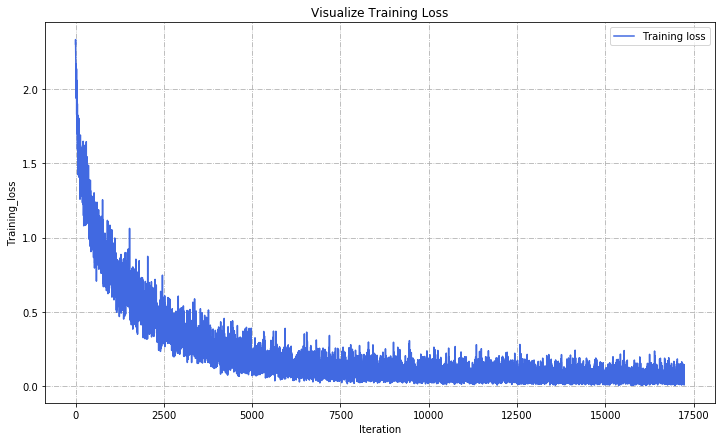

In [111]:
visualize_loss_curve(training_loss)

可视化查看验证集准确率上升的曲线

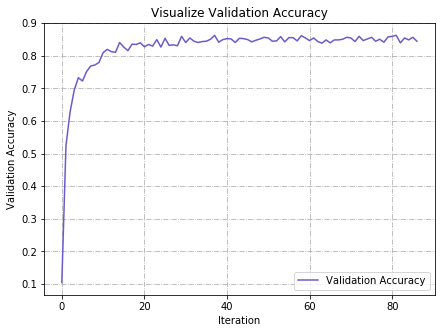

In [113]:
visualize_accuracy(validation_accuracy)

最终，这个模型达到了验证集85%+，测试集84%的分类准确率

# 对激活函数探索

Alex Krizhevsky在经典网络AlexNet中首次让每个卷积层和全连接层都使用ReLU激活，而不是tanh激活函数，实验结果表明使用ReLU可以让模型的收敛速度提升六倍左右，在本次作业中，我做一点简单的尝试比较二者的表现。

我们对网络进行二次修改，如下

In [143]:
model_trial = None
optimizer_trial = None
# 修改我们之前修改过的网络，对比激活函数表现
class Modified_Alex_Net_Test(nn.Module):
    def __init__(self, num_classes=10):
        super(Modified_Alex_Net_Test, self).__init__()
        # ReLU 函数
        # inplace = True 让ReLU 不需要介入一个中间变量就可以直接更新
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.Tanh(),
#             nn.MaxPool2d(kernel_size=2),
            # AlexNet的原文中的池化层可以依据情况删去

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.Tanh(),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.Tanh(),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        # 此处是自适应平均池化函数
        # 自动计算kernel size和step

        self.classifier = nn.Sequential(
            nn.Dropout(0.5), # 默认dropout = 0.5
            nn.Linear(256 * 7 * 7, 4096),
            nn.Tanh(),
            nn.Dropout(0.5), # 默认dropout = 0.5
            nn.Linear(4096, 4096),
            nn.Tanh(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x: Tensor = self.avgpool(x)
        x = x.view(-1, 7 * 7 * 256)
        x = self.classifier(x)
        return x

In [144]:
tanh_model = Modified_Alex_Net_Test()
tw.model_stats(tanh_model, [1, 3, 224, 224])

,module name,input shape,output_shape,parameters,infer memory(MB),MAdd,Flops,MemRead(B),MemWrite(B),duration
0,features.0,"(1, 3, 224, 224)","(1, 64, 224, 224)","1,792",12.25,"173,408,256","89,915,392","609,280","12,845,056",0.019809
1,features.1,"(1, 64, 224, 224)","(1, 64, 224, 224)",0,12.25,0,0,0,0,0.000499
2,features.2,"(1, 64, 224, 224)","(1, 64, 112, 112)",0,3.0625,"3,211,264","3,211,264","12,845,056","3,211,264",0.001939
3,features.3,"(1, 64, 112, 112)","(1, 192, 112, 112)","110,784",9.1875,"2,774,532,096","1,389,674,496","3,654,400","9,633,792",0.003413
4,features.4,"(1, 192, 112, 112)","(1, 192, 112, 112)",0,9.1875,0,0,0,0,0.000333
5,features.5,"(1, 192, 112, 112)","(1, 384, 112, 112)","663,936",18.375,"16,647,192,576","8,328,413,184","12,289,536","19,267,584",0.012436
6,features.6,"(1, 384, 112, 112)","(1, 384, 112, 112)",0,18.375,0,0,0,0,0.000428
7,features.7,"(1, 384, 112, 112)","(1, 256, 112, 112)","884,992",12.25,"22,196,256,768","11,101,339,648","22,807,552","12,845,056",0.010745
8,features.8,"(1, 256, 112, 112)","(1, 256, 112, 112)",0,12.25,0,0,0,0,0.000335
9,avgpool,"(1, 256, 112, 112)","(1, 256, 7, 7)",0,0.0478515625,0,"3,625,216",0,0,0.000493


In [145]:
trial_model = Modified_Alex_Net_Test().to(device) # 
learning_rate = 5e-4
optimizer=optim.Adam(trial_model.parameters(),
                     lr=learning_rate, 
                     weight_decay=1e-5)

训练一个用tanh激活函数的网络，只跑10个epoch来检测二者的性能差异

In [ ]:
tanh_training_loss = []
tanh_validation_accuracy = []

def train_model(model, optimizer, epochs=1):
    iter = 0
    model = model.to(device=device)  
    # 加载模型到GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  
            # 模型训练
            x = x.to(device=device, dtype=dtype) 
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            tanh_training_loss.append(loss.item()) # append数据用于可视化
            optimizer.zero_grad() # 梯度清空
            loss.backward() # 反向传播
            optimizer.step() # 使用优化方法更新           
            if iter % 200 == 0:
                print('Iteration %d, loss = %.4f' % (iter, loss.item()))
                tanh_validation_accuracy.append(check_model_accuracy(loader_val, model))
            iter = iter + 1

train_model(trial_model, optimizer, epochs=10)

In [151]:
len_data = len(tanh_training_loss)

In [164]:
def visualize_loss_curve2(data1,data2):
    line1,=plt.plot(data1,'royalblue',label='relu_training_loss')
    line2,=plt.plot(data2,'orangered',label='tanh_training_loss')
    plt.title('Visualize Training Loss')
    plt.legend(handles=[line1,line2],labels=['Relu Training loss','Tanh Training loss'], loc='best')
    plt.grid(linestyle='-.')
    plt.gcf().set_size_inches(12, 7)
    plt.xlabel('Iteration')
    plt.ylabel('Training_loss')
    plt.show()

打印10个epoch的损失信息，比较ReLU和Tanh激活函数在这个问题上的性能差异

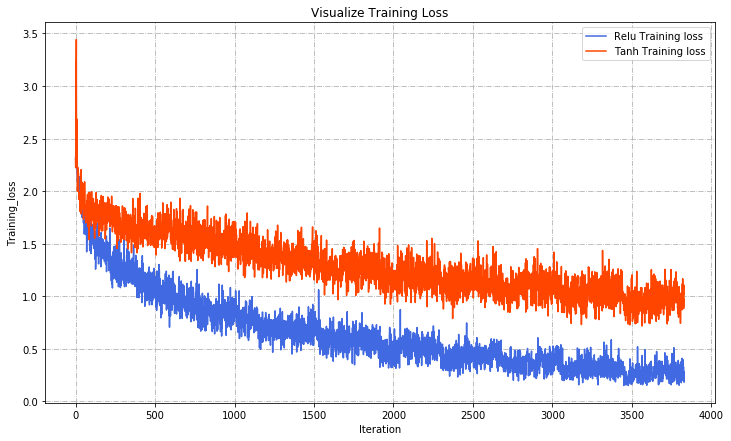

In [165]:
visualize_loss_curve2(training_loss[0:len_data],tanh_training_loss)

如上图所示，我们可以明显的看到，在参数设置完全相同的情况下，ReLU激活函数的表现优于Tanh激活函数，**使用ReLU激活函数的收敛速度相比Tanh快很多。**

**End of Homework4**